In [174]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from yahoo_fin.stock_info import get_data

In [175]:
ticker_name = "TSLA" #ticker name of stock
stock_price = get_data(ticker_name, start_date="12/04/2009", index_as_date=True)
stock_price.tail()

,open,high,low,close,adjclose,volume,ticker
2023-04-04,197.320007,198.740005,190.320007,192.580002,192.580002,126463800,TSLA
2023-04-05,190.520004,190.679993,183.759995,185.520004,185.520004,133882500,TSLA
2023-04-06,183.080002,186.389999,179.740005,185.059998,185.059998,123857900,TSLA
2023-04-10,179.940002,185.100006,176.110001,184.509995,184.509995,141873200,TSLA
2023-04-11,186.690002,189.190002,185.649994,188.830002,188.830002,54373734,TSLA


In [176]:
len(stock_price['close']), stock_price.isnull().sum()

(3218,
 open        0
 high        0
 low         0
 close       0
 adjclose    0
 volume      0
 ticker      0
 dtype: int64)

In [177]:
stock_price = stock_price.dropna()
stock_price.isnull().sum()
stock_price.reset_index();

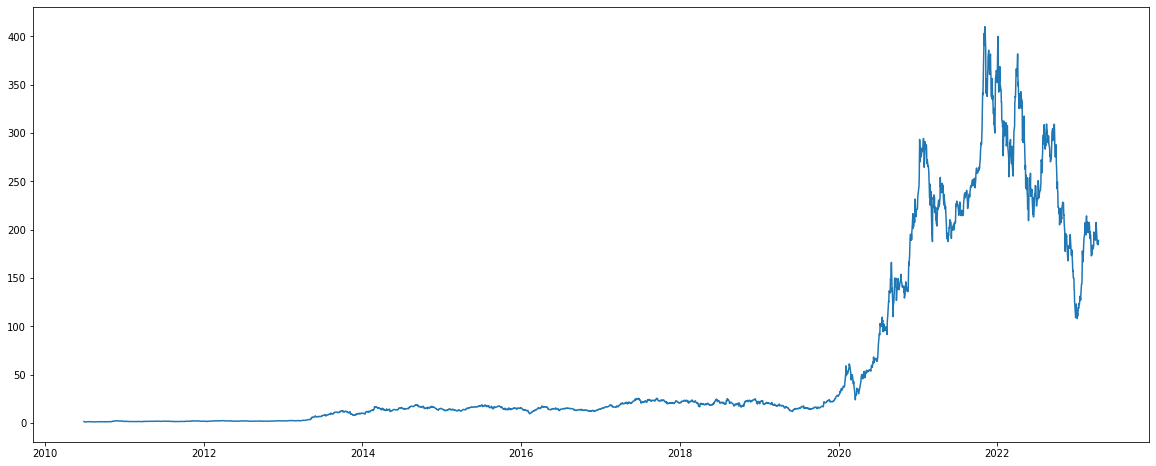

In [178]:
plt.figure(figsize=(20, 8))
plt.plot(stock_price['close'])

In [179]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(0, 1))
data = scaler.fit_transform(np.array(stock_price['close']).reshape(-1,1))


In [180]:

pd.DataFrame(data).isnull().sum()

0    0
dtype: int64

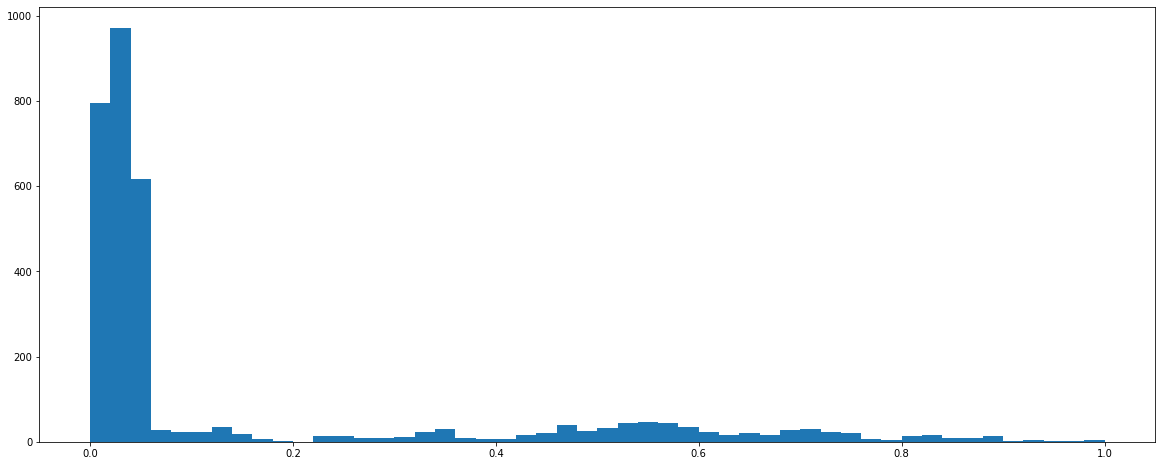

In [181]:
plt.figure(figsize=(20, 8))
plt.hist(data, bins=50);

In [182]:
training_size = int(len(data)*0.7)
test_size = len(data)-training_size
train_data, test_data = data[0:training_size,:], data[training_size:len(data), :1]

In [183]:
train_data.shape, test_data.shape, data.shape

((2252, 1), (966, 1), (3218, 1))

In [184]:
def create_dataset(dataset, timestep = 1):
    X, Y = [], []
    for i in range(len(dataset)-timestep-1):
        X.append(dataset[i:(i+timestep), 0])
        Y.append(dataset[i+timestep,0])
    return np.array(X), np.array(Y)

In [185]:
time_step = 300 #experiment with this parameter
X_train, y_train = create_dataset(train_data, timestep = time_step)
X_test, y_test = create_dataset(test_data, timestep = time_step)
X_train.shape

(1951, 300)

In [186]:
 X_trian = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
 X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [187]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [188]:
model = Sequential([
    LSTM(50,activation='relu', return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, activation='relu', return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1),
]) # experiment the composition of the layer 

model.compile(loss = 'mse', optimizer='adam')


In [189]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 300, 50)           10400     
                                                                 
 lstm_13 (LSTM)              (None, 300, 50)           20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [190]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10, batch_size = 32, verbose=1) #experiment with epochs & batch_size

Epoch 1/10
61/61 [==============================] - 24s 345ms/step - loss: 2.1723e-04 - val_loss: 0.0789
Epoch 2/10
61/61 [==============================] - 21s 338ms/step - loss: 1.3190e-05 - val_loss: 0.0505
Epoch 3/10
61/61 [==============================] - 21s 349ms/step - loss: 1.0697e-05 - val_loss: 0.0434
Epoch 4/10
61/61 [==============================] - 21s 348ms/step - loss: 1.0504e-05 - val_loss: 0.0396
Epoch 5/10
61/61 [==============================] - 20s 328ms/step - loss: 1.1683e-05 - val_loss: 0.0454
Epoch 6/10
61/61 [==============================] - 21s 353ms/step - loss: 9.3346e-06 - val_loss: 0.0459
Epoch 7/10
61/61 [==============================] - 19s 309ms/step - loss: 9.0841e-06 - val_loss: 0.0403
Epoch 8/10
61/61 [==============================] - 19s 308ms/step - loss: 9.4412e-06 - val_loss: 0.0455
Epoch 9/10
61/61 [==============================] - 20s 321ms/step - loss: 8.8614e-06 - val_loss: 0.0457
Epoch 10/10
61/61 [==============================] - 22

In [191]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

21/21 [==============================] - 7s 235ms/step


In [192]:
# transform to the original form 
train_pred = scaler.inverse_transform(train_predict)
test_pred= scaler.inverse_transform(test_predict)


In [193]:
y_train = y_train.reshape(-1,1)
y_test  = y_test.reshape(-1,1)
y_train.shape,  y_test.shape

((1951, 1), (665, 1))

In [194]:
# tranform to original form
y_tr = scaler.inverse_transform(y_train)
y_te = scaler.inverse_transform(y_test)


In [195]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [196]:
# train evaluation
rmse = mean_squared_error(train_pred, y_tr, squared = False)
mse = mean_squared_error(train_pred, y_tr, squared = True)
mae = mean_absolute_error(train_pred, y_tr)
print(f"mean : {y_tr.mean()}")
print(f"test evals: \n \t rmse : {rmse} \n \t mse: {mse} \n \t mae : {mae}")

mean : 13.390815976520248
test evals: 
 	 rmse : 1.0942073340737553 
 	 mse: 1.1972896899407945 
 	 mae : 0.7767835213916843


In [197]:
# test evaluation
rmse = mean_squared_error(test_pred, y_te, squared = False)
mse = mean_squared_error(test_pred, y_te, squared = True)
mae = mean_absolute_error(test_pred, y_te)
print(f"mean: {y_te.mean()}")
print(f"test evals: \n \t rmse : {rmse} \n \t mse: {mse} \n \t mae : {mae}")

mean: 238.38630477790545
test evals: 
 	 rmse : 88.13014640535435 
 	 mse: 7766.922705429193 
 	 mae : 82.67575579765148


In [198]:
data.shape, train_pred.shape, test_pred.shape

((3218, 1), (1951, 1), (665, 1))

In [199]:
print(var.shape)


(1103, 1)


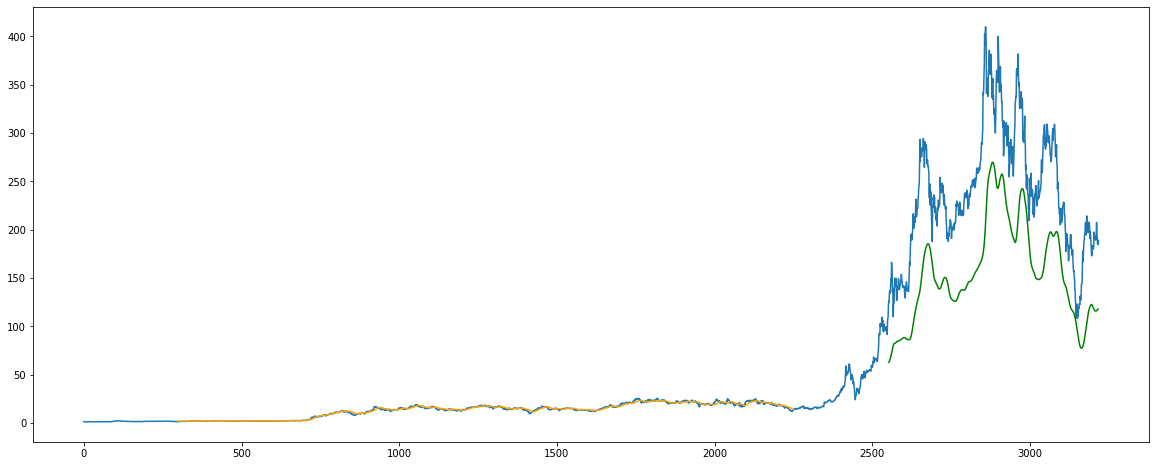

In [200]:
lags = time_step
var = data

# plot train_predict
train_pred_plot = np.empty_like(var)
train_pred_plot[:,:] = np.nan
train_pred_plot[lags:len(train_pred)+lags, :] = train_pred
# plot test_predict
test_pred_plot = np.empty_like(var)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred)+lags*2+1 : len(var)-1, :] = test_pred

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(var))
plt.plot(train_pred_plot, color='orange')
plt.plot(test_pred_plot, color='green')
plt.show()

# plt.figure(figsize=(20,8))
# plt.plot(scaler.inverse_transform(var)[1150:1258, :])
# plt.plot(train_pred_plot[1150:1258, :])
# plt.plot(test_pred_plot[1150:1258, :])
# plt.show()

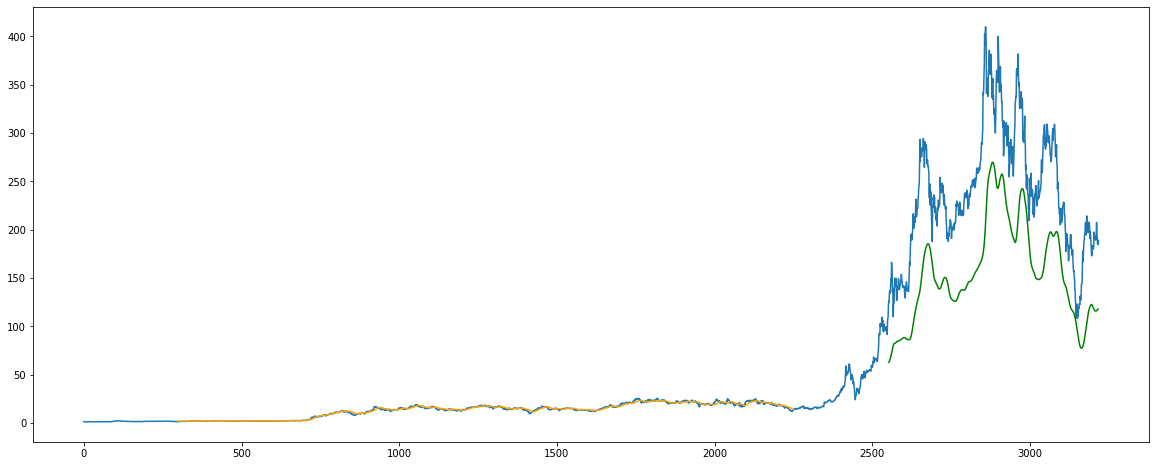

In [201]:
lags = time_step
var = data

# plot train_predict
train_pred_plot = np.empty_like(var)
train_pred_plot[:,:] = np.nan
train_pred_plot[lags:len(train_pred)+lags, :] = train_pred
# plot test_predict
test_pred_plot = np.empty_like(var)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred)+lags*2+1 : len(var)-1, :] = test_pred

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(var))
plt.plot(train_pred_plot, color='orange')
plt.plot(test_pred_plot, color='green')
plt.show()

# plt.figure(figsize=(20,8))
# plt.plot(scaler.inverse_transform(var)[1150:1258, :])
# plt.plot(train_pred_plot[1150:1258, :])
# plt.plot(test_pred_plot[1150:1258, :])
# plt.show()

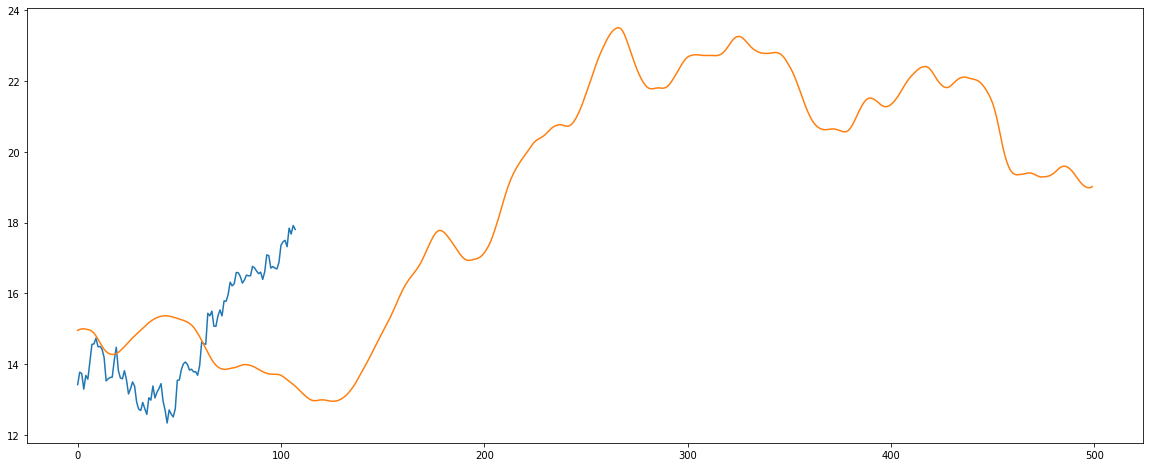

In [202]:
lags = time_step
var = data

# plot train_predict
train_pred_plot = np.empty_like(var)
train_pred_plot[:,:] = np.nan
train_pred_plot[lags:len(train_pred)+lags, :] = train_pred
# plot test_predict
test_pred_plot = np.empty_like(var)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred)+lags*2+1 : len(var)-1, :] = test_pred

# plt.figure(figsize=(20,8))
# plt.plot(scaler.inverse_transform(var))
# plt.plot(train_pred_plot, color='orange')
# plt.plot(test_pred_plot, color='green')
# plt.show()

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(var)[1150:1258, :])
plt.plot(train_pred_plot[1500:2000, :])
plt.plot(test_pred_plot[1500:2000, :])
plt.show()

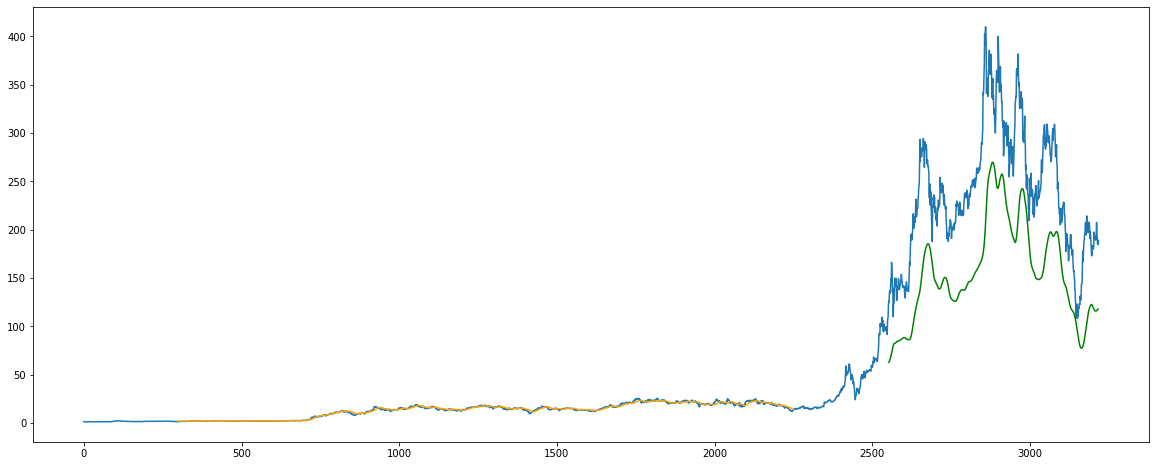

In [203]:
lags = time_step
var = data

# plot train_predict
train_pred_plot = np.empty_like(var)
train_pred_plot[:,:] = np.nan
train_pred_plot[lags:len(train_pred)+lags, :] = train_pred
# plot test_predict
test_pred_plot = np.empty_like(var)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred)+lags*2+1 : len(var)-1, :] = test_pred

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(var))
plt.plot(train_pred_plot, color='orange')
plt.plot(test_pred_plot, color='green')
plt.show()

# plt.figure(figsize=(20,8))
# plt.plot(scaler.inverse_transform(var)[1500:2000, :])
# plt.plot(train_pred_plot[1500:2000, :])
# plt.plot(test_pred_plot[1500:2000, :])
# plt.show()

In [204]:
l_t = len(test_data)

In [205]:
x_new = test_data[l_t-lags:]
x_new = x_new.reshape(1,-1)
t = x_new[0,-1].reshape(-1, 1)
l = []
forward = 30
for i in range(forward):
    val = model.predict(x_new)
    x_new = np.append(x_new[:,1:lags], val).reshape(1,-1)
    l.append(val.item())
l = np.array(l).reshape(-1,1)
L = scaler.inverse_transform(l)
L.shape


1/1 [==============================] - 0s 154ms/step


(30, 1)

In [206]:

T = scaler.inverse_transform(t)
L_final = np.append(T, L).reshape(-1,1)
L_final.shape, T

((31, 1), array([[188.83000183]]))

In [207]:
forward_plot_predict = np.empty([len(data)+forward,1])
forward_plot_predict[:, :] = np.nan
forward_plot_predict[len(data)-1:, :] = L_final
len(data), len(forward_plot_predict)

(3218, 3248)

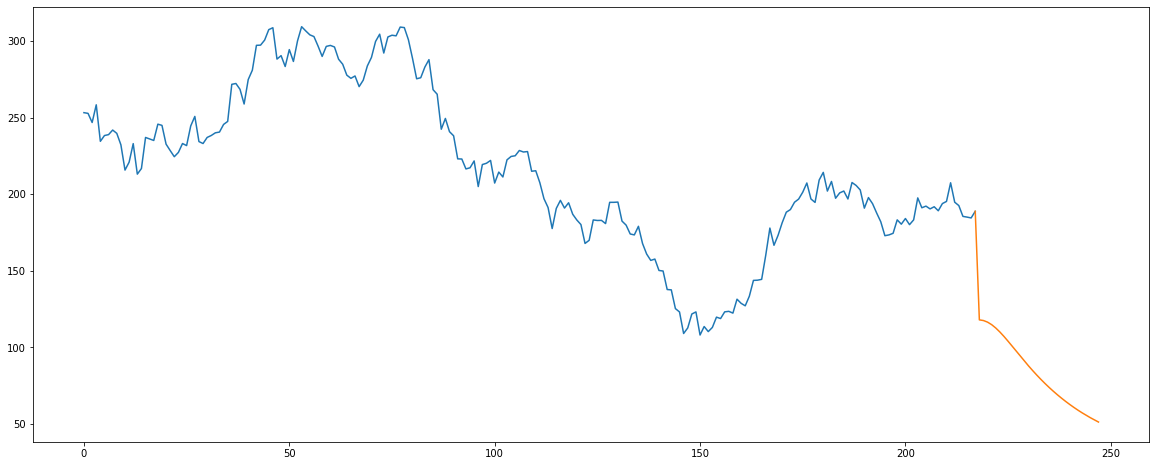

In [208]:
# plotting the graph
plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(data)[3000:,:])
plt.plot(forward_plot_predict[3000:, :])
plt.show()